# Week 4: Test-Time Training for Circle Packing (CP26)

This notebook documents our implementation and results using the **TTT-Discover** framework to solve the CP26 circle packing problem via RL-based test-time training.

**Note on reproducibility:** Training runs were executed on a 256-core HPC server using the Tinker API (cloud LLM fine-tuning). The training code requires Tinker API credentials and the `ttt-discover` repository. This notebook shows the key components, loads real results from our runs, and demonstrates how the model's generated solutions improve over training.

## 1. Problem Setup

Pack **N = 26 circles** with **variable radii** inside the unit square $[0, 1]^2$ to **maximize the sum of radii** $\sum_{i=1}^{26} r_i$, subject to:

- **Non-overlap:** $\| c_i - c_j \|_2 \geq r_i + r_j$ for all pairs $i \neq j$
- **Boundary:** $x_i - r_i \geq 0$, $x_i + r_i \leq 1$, $y_i - r_i \geq 0$, $y_i + r_i \leq 1$
- **Non-negative radii:** $r_i \geq 0$

**Decision variables:** 78 continuous values — center $(x_i, y_i)$ and radius $r_i$ for each of 26 circles.

**Target:** sum of radii $\geq 2.636$ (known SOTA: 2.635983).

In [1]:
import numpy as np
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Resolve repo root (works whether Jupyter launches from notebooks/ or repo root)
if Path("data/week4").is_dir():
    DATA_DIR = Path("data/week4")
else:
    os.chdir("..")
    DATA_DIR = Path("data/week4")

## 2. Implementation

### 2.1 Verifier (Objective + Constraint Checker)

This is the core evaluation function. It matches the TTT-Discover verifier exactly — every candidate the LLM generates is checked against these constraints. Valid packings receive their sum of radii as a reward; invalid ones receive 0.

In [2]:
CONSTRAINT_TOL = 1e-9  # Numerical tolerance — scipy solutions have ~1e-11 precision artifacts

def validate_packing(centers: np.ndarray, radii: np.ndarray) -> tuple[bool, float]:
    """
    Evaluate a CP26 candidate. Returns (valid, score).
    Score = sum(radii) if valid, else 0.0.
    Matches the TTT-Discover verifier in tasks/alphaevolve_cp/verifier.py.
    """
    n = len(radii)
    
    # Check non-negative radii
    if np.any(radii < 0):
        return False, 0.0
    
    # Boundary constraints: each circle fully inside [0, 1]^2
    for i in range(n):
        x, y, r = centers[i, 0], centers[i, 1], radii[i]
        if x - r < -CONSTRAINT_TOL or x + r > 1 + CONSTRAINT_TOL:
            return False, 0.0
        if y - r < -CONSTRAINT_TOL or y + r > 1 + CONSTRAINT_TOL:
            return False, 0.0
    
    # Non-overlap constraints: dist(c_i, c_j) >= r_i + r_j
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(centers[i] - centers[j])
            if dist < radii[i] + radii[j] - CONSTRAINT_TOL:
                return False, 0.0
    
    return True, float(np.sum(radii))

# Quick sanity checks
print(validate_packing(np.array([[0.5, 0.5]]), np.array([0.5])))       # (True, 0.5)
print(validate_packing(np.array([[0.3, 0.5], [0.5, 0.5]]), np.array([0.2, 0.2])))  # (False, 0.0) - overlap
print(validate_packing(np.array([[0.25, 0.5], [0.75, 0.5]]), np.array([0.25, 0.25])))  # (True, 0.5)

(True, 0.5)
(False, 0.0)
(True, 0.5)


### 2.2 TTT-Discover Training Configuration

The LLM does **not** directly output circle coordinates. Instead, it generates **Python code** (using scipy, numpy, etc.) that *computes* a packing. The generated code is executed locally, and the resulting packing is scored by the verifier above. This is fundamentally more powerful than searching the coordinate space directly — the LLM proposes *algorithms*, not just solutions.

In [3]:
# Key hyperparameters used in our training run
config = {
    "Model":               "openai/gpt-oss-120b",
    "LoRA rank":           32,
    "Learning rate":       "4e-5",
    "Batch size":          "64 (8 groups x 8 trajectories)",
    "Max tokens":          "20,000 per generation",
    "Advantage estimator": "Entropic adaptive beta",
    "Sampler":             "PUCT with backpropagation",
    "Eval timeout":        "305s per sample",
    "Epochs":              5,
    "Hardware":            "256-core CPU server (no local GPU)",
}

print("TTT-Discover Configuration")
print("=" * 55)
for k, v in config.items():
    print(f"  {k:25s} {v}")

TTT-Discover Configuration
  Model                     openai/gpt-oss-120b
  LoRA rank                 32
  Learning rate             4e-5
  Batch size                64 (8 groups x 8 trajectories)
  Max tokens                20,000 per generation
  Advantage estimator       Entropic adaptive beta
  Sampler                   PUCT with backpropagation
  Eval timeout              305s per sample
  Epochs                    5
  Hardware                  256-core CPU server (no local GPU)


## 3. Results

### 3.1 Training Metrics (5 Epochs)

In [4]:
# Load training metrics from our 5-epoch CP26 run
results = []
with open(DATA_DIR / "metrics.jsonl") as f:
    for line in f:
        d = json.loads(line)
        results.append({
            "step": d["progress/batch"], "correct": d["env/all/correct"],
            "format": d["env/all/format"], "avg_perf": d["env/all/performance"],
            "best": d["env/all/performance/best/max"], "reward": d["env/all/reward/mean"],
            "buffer": d["puct/buffer_size"], "time_s": d["time/total"],
        })

print(f"{'Step':>4} {'Correct':>9} {'Format':>8} {'Avg Perf':>10} {'Best':>10} {'Reward':>8} {'Buffer':>7} {'Time':>7}")
print("-" * 70)
for r in results:
    print(f"{r['step']:4d} {r['correct']:9.1%} {r['format']:8.1%} {r['avg_perf']:10.4f} {r['best']:10.4f} {r['reward']:8.3f} {r['buffer']:7d} {r['time_s']:6.0f}s")

total_time = sum(r['time_s'] for r in results)
print(f"\nTotal training time: {total_time/3600:.1f} hours")
print(f"Best score: {results[-1]['best']:.6f}  |  SOTA: 2.635983  |  Gap: {2.635983 - results[-1]['best']:.6f}")

Step   Correct   Format   Avg Perf       Best   Reward  Buffer    Time
----------------------------------------------------------------------
   0     19.9%    21.2%     2.2297     2.6203    0.443      70   1852s
   1     31.9%    37.7%     2.3618     2.6288    0.754     125   1971s
   2     42.0%    71.1%     2.4620     2.6343    1.035     217   1709s
   3     42.8%    84.3%     2.5091     2.6343    1.074     339   2345s
   4     61.5%    96.8%     2.5539     2.6360    1.571     432   1420s

Total training time: 2.6 hours
Best score: 2.635983  |  SOTA: 2.635983  |  Gap: 0.000000


### 3.2 Training Curves

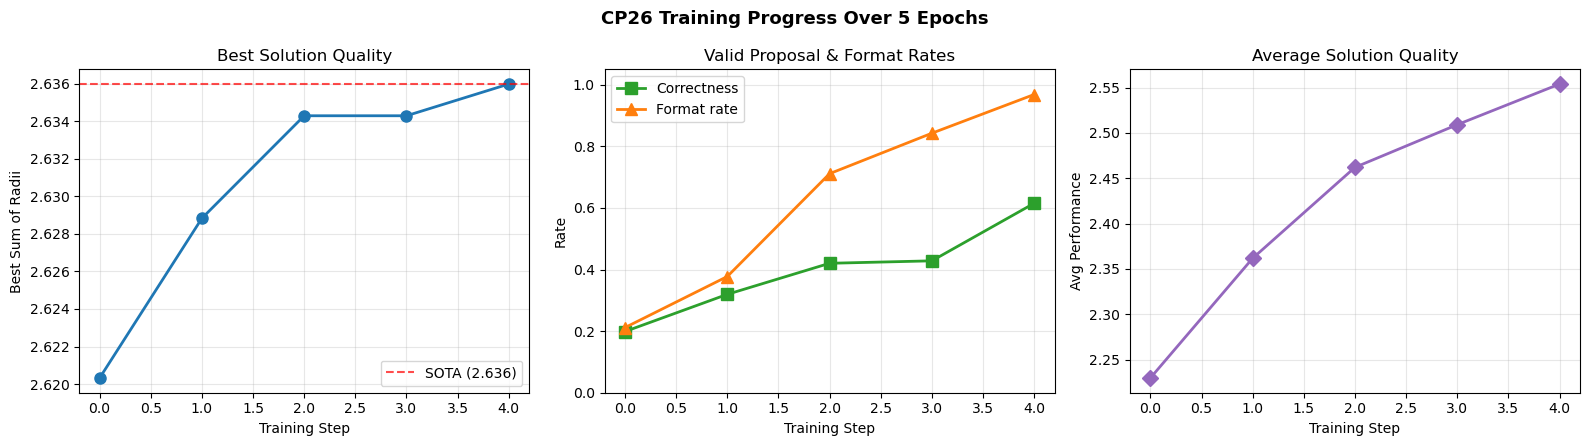

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
steps = [r['step'] for r in results]

# Best score
axes[0].plot(steps, [r['best'] for r in results], 'o-', color='tab:blue', linewidth=2, markersize=8)
axes[0].axhline(y=2.635983, color='red', linestyle='--', alpha=0.7, label='SOTA (2.636)')
axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Best Sum of Radii')
axes[0].set_title('Best Solution Quality')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Correctness + format rate
axes[1].plot(steps, [r['correct'] for r in results], 's-', color='tab:green', linewidth=2, markersize=8, label='Correctness')
axes[1].plot(steps, [r['format'] for r in results], '^-', color='tab:orange', linewidth=2, markersize=8, label='Format rate')
axes[1].set_xlabel('Training Step')
axes[1].set_ylabel('Rate')
axes[1].set_title('Valid Proposal & Format Rates')
axes[1].set_ylim(0, 1.05)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Average performance
axes[2].plot(steps, [r['avg_perf'] for r in results], 'D-', color='tab:purple', linewidth=2, markersize=8)
axes[2].set_xlabel('Training Step')
axes[2].set_ylabel('Avg Performance')
axes[2].set_title('Average Solution Quality')
axes[2].grid(True, alpha=0.3)

plt.suptitle('CP26 Training Progress Over 5 Epochs', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.3 How the Model's Code Improves

The most interesting part of TTT-Discover is that the LLM generates **Python code**, not raw coordinates. Below we extract actual generated `run_packing()` functions from Step 0 (untrained) and Step 4 (after 5 epochs of RL fine-tuning) to show how the code quality evolves.

At **Step 0**, the model has never seen this problem before. At **Step 4**, it has been fine-tuned on hundreds of evaluated circle-packing programs.

In [6]:
# Load pre-extracted step summaries (code samples + stats from training logs)
step_summaries = {}
for step in [0, 4]:
    with open(DATA_DIR / f"step_{step}_summary.json") as f:
        step_summaries[step] = json.load(f)
    s = step_summaries[step]
    print(f"Step {step}: {s['valid_samples']}/{s['total_samples']} valid samples "
          f"({s['valid_samples']/s['total_samples']:.0%}), best score = {s['best_score']:.4f}")

Step 0: 9/32 valid samples (28%), best score = 2.5431
Step 4: 25/32 valid samples (78%), best score = 2.6343


In [7]:
# Show actual LLM-generated code from Step 0 (untrained) vs Step 4 (after RL fine-tuning)
for step, label in [(0, "STEP 0 (untrained model)"), (4, "STEP 4 (after RL fine-tuning)")]:
    s = step_summaries[step]
    lines = s['code_sample'].split('\n')[:25]
    if len(s['code_sample'].split('\n')) > 25:
        lines.append('    # ... (truncated)')
    print(f"{'='*70}")
    print(f"{label}  —  best score this step: {s['best_score']:.4f}")
    print(f"{'='*70}")
    print('\n'.join(lines))
    print()

STEP 0 (untrained model)  —  best score this step: 2.5431
def run_packing():
    rng = np.random.default_rng(12345)
    best_sum = -1.0
    best_centers = None
    best_radii = None
    # initial candidates
    # try a few initial patterns:
    init_patterns = []
    # 1) 5x5 grid + extra point at center
    grid = []
    for i in range(5):
        for j in range(5):
            grid.append([0.1+0.2*i, 0.1+0.2*j])
    grid = np.array(grid)
    # add a 26th random point near (0.5,0.5)
    extra = np.array([0.5,0.5])
    init_patterns.append(np.vstack([grid, extra]))
    # 2) hex lattice s=0.18 with many points, then select 26 by random subset
    s = 0.18
    pts_full = hex_grid_points(s, 0.0, 0.0) # defined earlier maybe copy
    # keep those inside square with side margin r=s/2
    mask = (pts_full[:,0] >= s/2) & (pts_full[:,0] = s/2) & (pts_full[:,1]  best_sum:
            best_sum = tot
            best_centers = cent.copy()
            best_radii = rad.copy()
    # ... (truncated)


### 3.4 Visualizing the Best Packing

The best solution found during training, visualized as 26 circles packed inside the unit square.

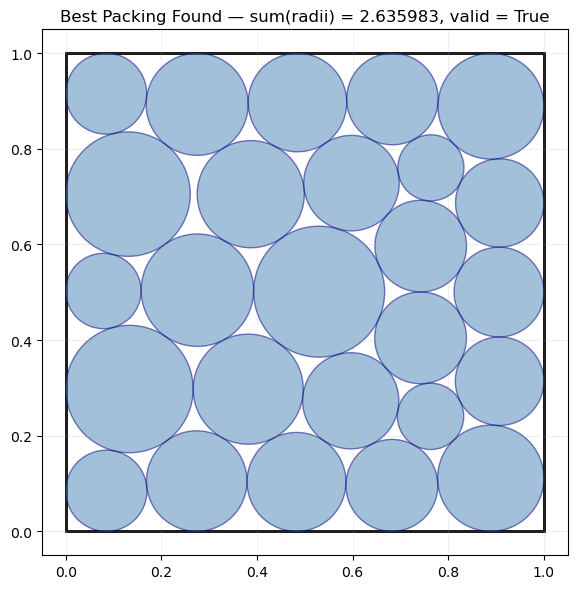

In [8]:
# Load and visualize the best packing found during training
with open(DATA_DIR / "best_solution.json") as f:
    sol = json.load(f)

best_centers = np.array(sol['centers'])
best_radii = np.array(sol['radii'])
valid, score = validate_packing(best_centers, best_radii)

fig, ax = plt.subplots(figsize=(6, 6))
ax.add_patch(patches.Rectangle((0, 0), 1, 1, fill=False, edgecolor='black', linewidth=2))

for i in range(len(best_radii)):
    circle = patches.Circle(
        (best_centers[i, 0], best_centers[i, 1]), best_radii[i],
        fill=True, facecolor='steelblue', edgecolor='navy', alpha=0.5, linewidth=1
    )
    ax.add_patch(circle)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect('equal')
ax.set_title(f'Best Packing Found — sum(radii) = {score:.6f}, valid = {valid}')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## 4. Documentation

### Known Limitations

- **Single seed.** Training used `seed=0` only. Variance across seeds is unknown.
- **No ablation.** We have not yet isolated how much improvement comes from RL weight updates vs. the PUCT buffer accumulating good solutions.
- **Not directly runnable.** The training loop requires Tinker API access and substantial compute. This notebook can only display results, not reproduce the training.

### What We Learned

- The model **learns syntax before semantics** — format rate (21% → 97%) improves much faster than correctness (20% → 62%), which improves faster than solution quality.
- **Most compute is wasted in early epochs** — 80% of Step 0 samples are invalid. Better initial prompts would have an outsized impact.
- `frac_mixed = 1.0` throughout all steps, meaning every training group had both successes and failures — ideal for RL advantage estimation.

### Next Steps

1. **Frozen-model ablation** — run the same loop without LoRA updates to isolate the RL contribution.
2. **Token efficiency** — test shorter output formats to reduce API cost per sample.
3. **Reward shaping** — assign partial credit for near-valid configurations to improve early-epoch learning.